### Ornstein Uhlenbeck Process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from FinancialMachineLearning.backtest.backtest_synthetic_data import *

### Framework

지금까지 관측값으로부터 $\pi_{i,t}$가 추출된 확률 프로세스를 특별히 특징지은적이 없다. 여기서는 $\pi_{i,t}$가 계열 상관성을 보일 때와 같은 과적합이 가장 해로운 시나리오들에 대해서 최적 거래 규칙을 찾는 데 관심이 있다. 특히 가격에 대한 이산 Ornstein uhlenbeck process를 가정해 보자.

$$P_{i,t} = (1 - \varphi) E_0\left[P_{i,T_i}\right] + \varphi P_{i, t-1} + \sigma \epsilon_{i,t}$$

여기서 random shock는 IID분포의 $\epsilon_{i,t} \sim N(0,1)$이다. 이 프로세스의 시드값은 $P_{i,0}$, 기회 $i$에 의한 목표 수준이 $E_0[P_{i, T_i}]$이고, $\varphi$는 $P_{i,0}$이 $E_0 \left[P_{i, T_i}\right]$로의 수렴 속도를 결정한다. $\phi_{i,t} = m_i (P_{i,t} - P_{i,0})$이므로 위 식의 기회 $i$의 성과는 다음 프로세스에 의해 특성화된다는 것을 암시한다.

$$\frac{1}{m_i}\pi_{i,t} = (1 - \varphi)E_0\left[P_{i,T_i}\right] - P_{i,0} + \varphi P_{i,t-1} + \sigma \epsilon_{i,t}$$

Bailey, Lopez de Prado (2013)의 명제 4 증명으로부터 위 식의 프로세스의 분포는 다음과 같은 parameter를 가진 가우시안 분포라는 것을 증명할 수 있다.

$$\pi_{i,t} \sim N \left[
m_i \left( 
    (1 - \varphi) E_0 \left[ P_{i, T_i}\right] \sum_{j=0}^{t-1} \varphi^j - P_{i,0}
\right), m_i^2 \sigma^2 \sum_{j=0}^{t-1} \varphi^{2j}
\right]$$

또한 정상성의 필요 충분 조건은 $\varphi \in (-1, 1)$이다. 입력 파라미터 $\{\sigma, \varphi\}$ 집합과 기회 $i$와 연관된 초기 조건 $\{P_{i,0}, E_0[P_{i,T_i}]\}$가 주어질 때 최적 매매 규칙 $R^* : = (\underline{\pi}, \bar{\pi})$이 존재하는가? 이와 유사하게 전략 $S$가 수익 목표 $\bar{\pi}$를 예측한다면 주어진 입력값 $\{\sigma, \varphi\}$에 대한 최적 losscut $\underline{\pi}$를 계산할 수 있는가? 만약 그 대답이 참이라면 $R^*$을 결정하기 위판 백테스트가 필요 없어 Trading Rule의 과적합 문제를 피할 수 있다. 아래의 과정은 이런 문제에 실험적으로 답하는 방법을 알려준다.

### Numerical Determination of Optimal Trading Rules

위에서 Ornstein Uhlenbeck 설정을 통해 전략 $S$의 수익률을 생성하는 확률 프로세스를 특징지었다. 이번절에서는 일반적으로 어떤 설정에 관해서도, 특히 Ornstein Uhlenbeck Process에 대해서도 최적 거래 규칙을 수치적으로 도출할 수 있는 절차를 설명한다.

#### 1. Algorithm

알고리즘은 5개의 순차적 단계로 이뤄진다.

1단계 : 식 $P_{i,t} = (1 - \varphi) E_0\left[P_{i,T_i}\right] + \varphi P_{i, t-1} + \sigma \epsilon_{i,t}$을 선형화해 입력 parameter $\{\sigma, \varphi\}$를 다음과 같이 추정한다.

$$P_{i,t} = E_0\left[P_{i,T_i}\right] + \varphi (P_{i, t-1} - E_0[P_{i, T_i}])+ \xi_t$$

그 다음 기회를 순차화하여 vector $X$와 $Y$를 형성한다.

$$X = 
\begin{bmatrix}
P_{0,0} - E_0[P_{0, T_0}] \\
P_{0,1} - E_0[P_{0, T_0}] \\
\cdots \\
P_{0,T-1} - E_0[P_{0, T_0}] \\
\cdots \\
P_{I,0} - E_0[P_{I, T_I}] \\
\cdots \\
P_{I,T-1} - E_0[P_{I, T_I}] 
\end{bmatrix} ;

Y = \begin{bmatrix}
P_{0,1}\\
P_{0,2}\\
\cdots \\
P_{0,T}\\
\cdots \\
P_{I,1}\\
\cdots \\
P_{I,T}
\end{bmatrix} ;

Z = \begin{bmatrix}
E_0[P_{0, T_0}] \\
E_0[P_{0, T_0}] \\
\cdots \\
E_0[P_{0, T_0}] \\
\cdots \\
E_0[P_{I, T_I}] \\
\cdots \\
E_0[P_{I, T_I}] 
\end{bmatrix} ;
$$

식 $P_{i,t} = E_0\left[P_{i,T_i}\right] + \varphi (P_{i, t-1} - E_0[P_{i, T_i}])+ \xi_t$에 OLS를 적용하면 원시 Ornstein Uhlenbeck Process의 parameter를 다음과 같이 계산할 수 있다.

$$\hat{\varphi} = \frac{\sigma_{Y,X}}{\sigma_{X}^2}$$
$$\hat{\xi}_t = Y - Z - \hat{\varphi}X$$
$$\hat{\sigma} = \sqrt{\sigma_{\hat{\xi}_t, \hat{\xi}_t}}$$

여기서 $\sigma_{\dot, dot}$은 공분산 연산자이다.

2단계 : loss cut과 profit taking pairs $\left( \underline{\pi}, \bar{\pi}\right)$의 격자를 만든다. 예를 들어서, $\underline{\pi} = \left\{ -\frac{1}{2}\sigma, -\sigma, \dots, -10\sigma\right\}$와 $\bar{\pi} = \left\{ \frac{1}{2}\sigma, \sigma, \dots, 10\sigma\right\}$의 카티션 곱은 $20 \times 20$의 노드를 생성하고 각각은 대안 trading rule $R \in \Omega$를 구성한다.

3단계 : $\pi_{i,t}$에 추정값 $\{\hat{\sigma}, \hat{\varphi}\}$을 적용해 $\pi_{i,t}$를 위한 많은 수의 경로를 생성한다. 시드값으로 기회 $i$와 연계된 관측 초기 조건 $\{P_{i,0}, E_0[P_{i, T_i}]\}$를 사용한다. 포지션은 무한정 보유할 수 있는 것이 아니므로 $\underline{\pi} \leq \pi_{i, 100} \leq \bar{\pi}$이더라도 포지션을 청산할 최대 보유 기간을 설정한다. 이 최대 보유 기간은 triple barrier method의 수직 바와 동일하다.

4단계 : 3단계에서 생성한 100,000개의 경로를 각각 2단계에서 생성한 $20 \times 20$격자 $(\underline{\pi}, \bar{\pi})$에 적용한다. 각 노드에 대해 loss cut과 profit taking 논리를 적용하면 $\pi_{i, T_i}$의 값 100,000개가 생성된다. 이와 마찬가지로 각 노드에 대해서 trading rule과 연계된 Sharpe ratio를 계산한다. 이 단계의 결과는 다음과 같은 세 가지 방법으로 사용될 수 있다.

5a단계 : Trading rule에서 주어진 입력 parameter $\{\hat{\sigma}, \hat{\varphi}\}$와 관측된 초기 조건 $\{P_{i,0}, E_0[P_{i, T_i}]\}$에 대해 최적이 되는 거래 규칙 격자 내에서의 쌍 $(\underline{\pi}, \bar{\pi})$을 결정한다.

5b단계 : 전략 $S$가 특정 기회 $i$에 대해 목표 이익 $\bar{\pi}_i$를 제공하면 이 정보를 4단계의 결과와 결합해 최적의 loss cut $\underline{\pi}_i$를 결정할 수 있다.

5c단계 : 트레이더가 기회 $i$에 대해 펀드 관리에 의해 부여된 최대 loss cut 구간 $\underline{\pi}_i$를 가지면 이 정보를 4단계의 결과와 결합해 loss cut 범위 $[0, \underline{\pi}_i]$ 내에서 최적의 profit taking 구간인 $\bar{\pi}_i$를 결정할 수 있다.

Bailey, Lopez de Prado(2012)의 논문에서는 식 $P_{i,t} = (1 - \varphi) E_0\left[P_{i,T_i}\right] + \varphi P_{i, t-1} + \sigma \epsilon_{i,t}$의 프로세스의 반감기(half life)가 $\varphi \in (0, 1)$의 조건하에서 $\tau = - \frac{\log(2)}{\log(\varphi)}$라는 것을 증명했다. 그 결과로부터 특정 반감기 $\varphi$와 연계된 값 $\tau$를 $\varphi = 2^{-\frac{1}{\tau}}$로 결정할 수 있다.

#### 2. Implementation

아래의 코드는 위 과정을 파이썬으로 구현한 것이다. 이는 식 $P_{i,t} = E_0\left[P_{i,T_i}\right] + \varphi (P_{i, t-1} - E_0[P_{i, T_i}])+ \xi_t$의 확률 프로세스를 특징짓는다. 일반성을 잃지 않기 위해서 모든 시뮬레이션에서 $\sigma = 1$을 사용한다. 그 다음 각 쌍 $(E_0[P_{i,T_i}], \tau)$에 대해 함수 `synthetic_simulation()`는 다양한 거래 규칙과 연계된 sharpe ratio를 계산한다.

In [2]:
rPT = rSLm = np.linspace(0, 10, 41)
coeffs = {'forecast': 0, 'hl': 5, 'sigma': 1}
nIter = int(1e5)
maxHP = 100
seed = 0

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

In [3]:
output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

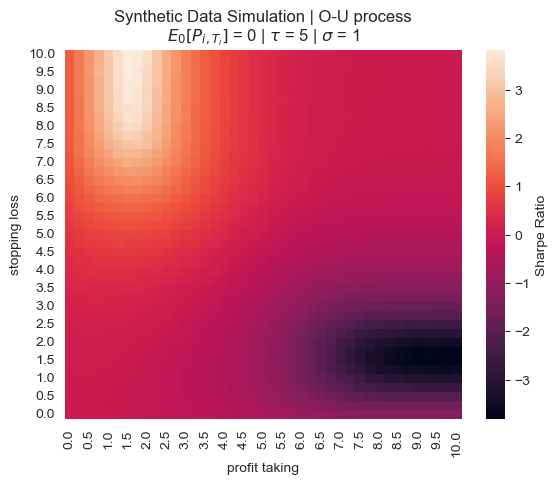

In [4]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [5]:
coeffs = {'forecast': 0, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

In [6]:
output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

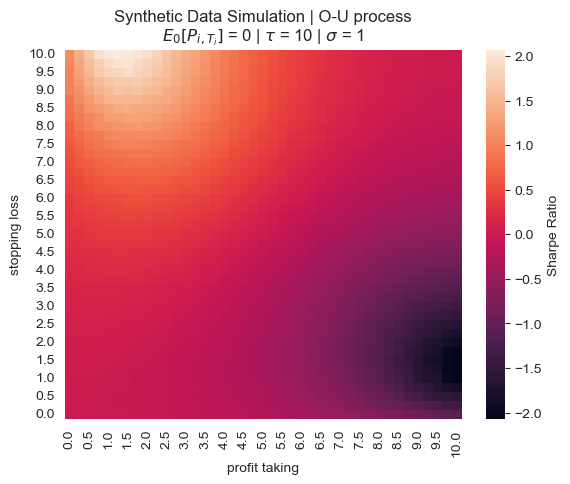

In [7]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [8]:
coeffs = {'forecast': 0, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

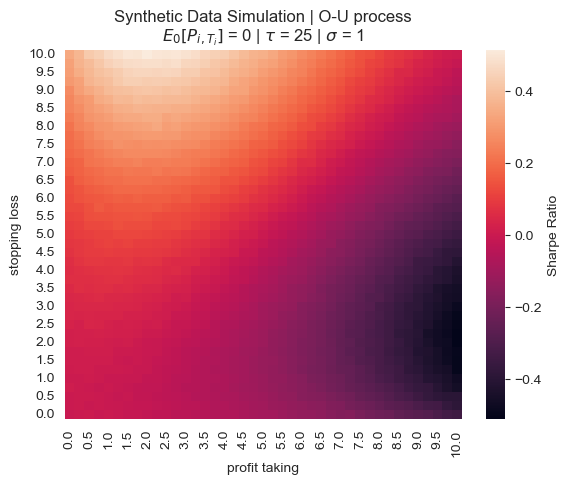

In [9]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [10]:
coeffs = {'forecast': 0, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

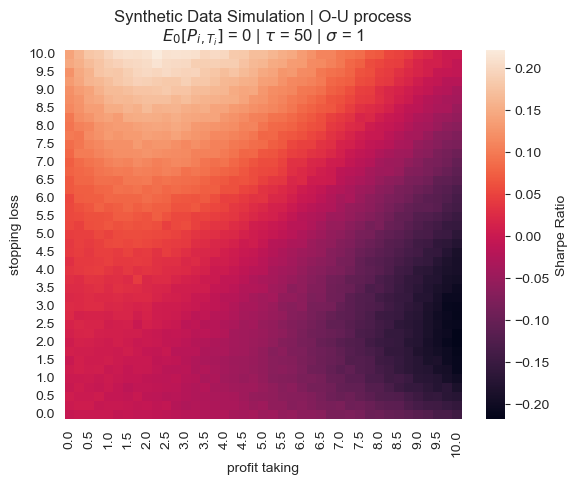

In [11]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [12]:
coeffs = {'forecast': 0, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

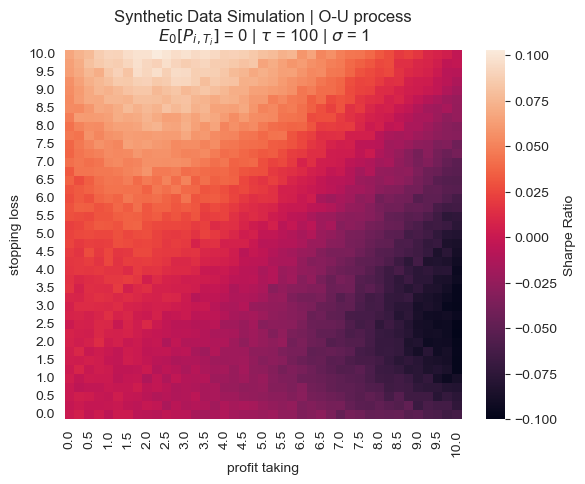

In [13]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

역사적 시뮬레이션에서 랜덤 워크의 거래 규칙을 조율하면 백테스트 과적합이 발생할 수 있다. 우연히 Sharpe ratio를 최대화하는 랜덤 조합의 profit taking과 loss cut이 선택되기 때문이다. 그러므로 synthetic data backtest가 매우 중요하다. 즉, 과거에 발생한 어떤 통계적 요행에 의존해 전략을 선택하는 것을 피한다. 위 실험에서 성과가 일관된 패턴을 보이지 않으면 Optimal Trading Rule이 존재하지 않는다는 것을 나타내므로 과적합을 방지할 수 있다.

#### 양의 장기 균형의 경우

In [14]:
coeffs = {'forecast': 5, 'hl': 5, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

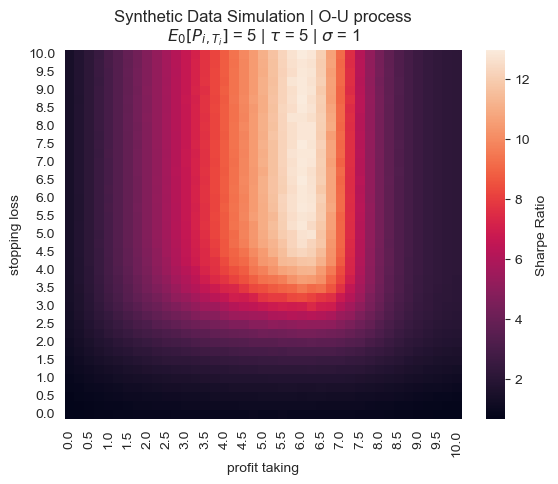

In [15]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [16]:
coeffs = {'forecast': 5, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

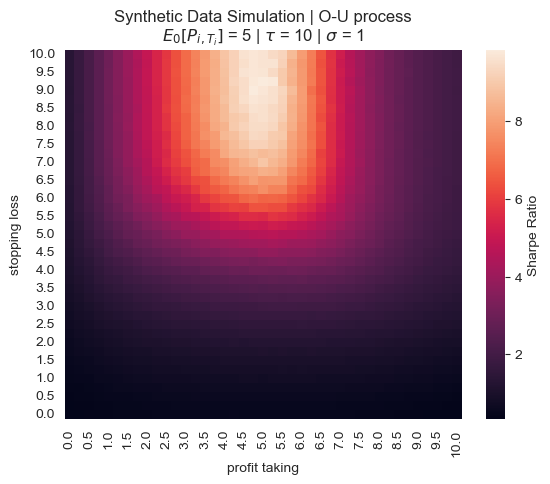

In [17]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [18]:
coeffs = {'forecast': 5, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

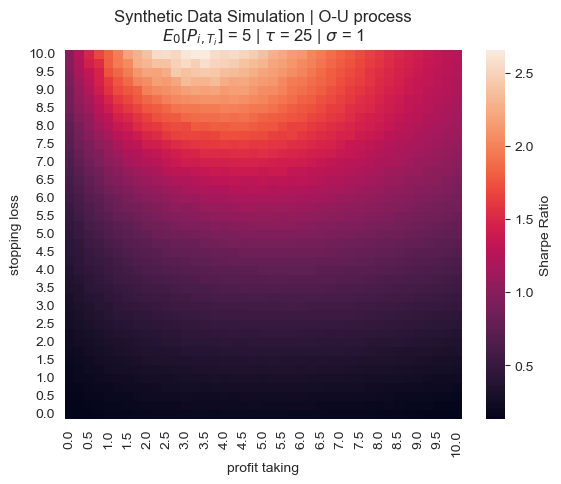

In [19]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [20]:
coeffs = {'forecast': 5, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

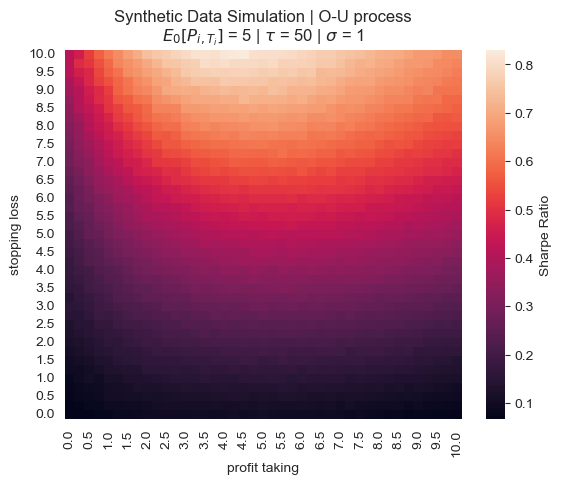

In [21]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [22]:
coeffs = {'forecast': 5, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

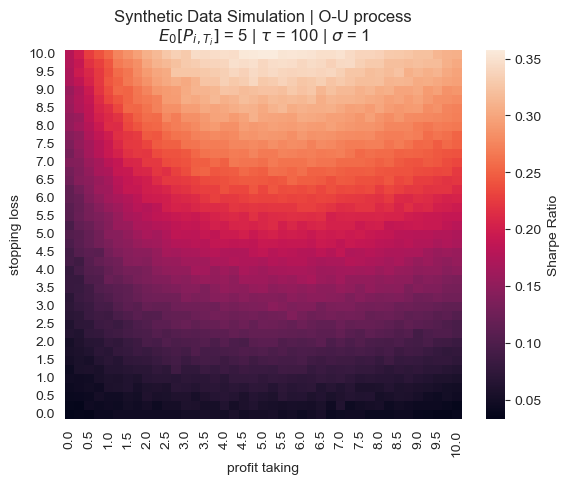

In [23]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 5 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [24]:
coeffs = {'forecast': 10, 'hl': 5, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

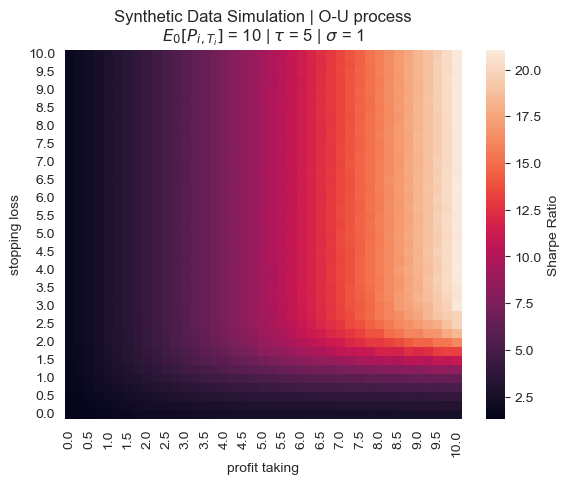

In [25]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 5 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [26]:
coeffs = {'forecast': 10, 'hl': 10, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

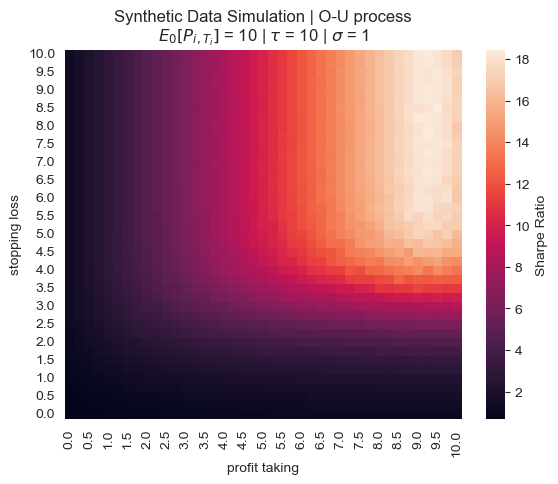

In [27]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 10 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [28]:
coeffs = {'forecast': 10, 'hl': 25, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

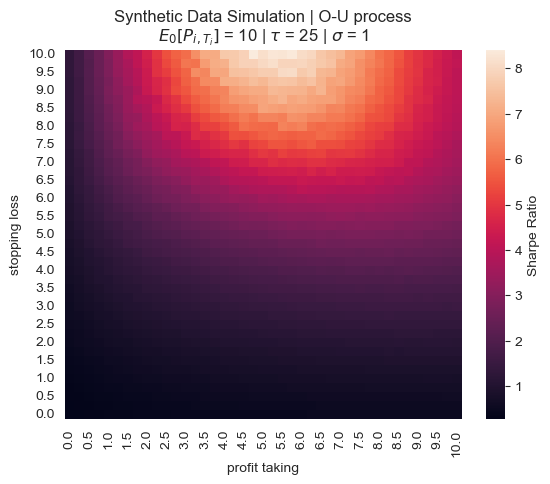

In [29]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 25 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [30]:
coeffs = {'forecast': 10, 'hl': 50, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

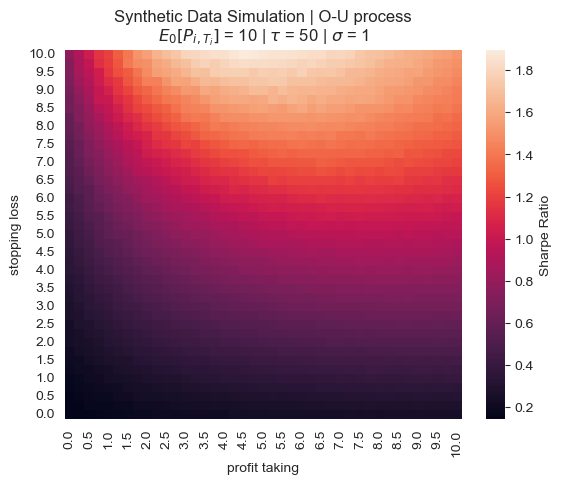

In [31]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 50 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

In [32]:
coeffs = {'forecast': 10, 'hl': 100, 'sigma': 1}

phi = 2 ** (-1. / coeffs['hl'])
forecast = coeffs['forecast']
sigma = coeffs['sigma']

output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

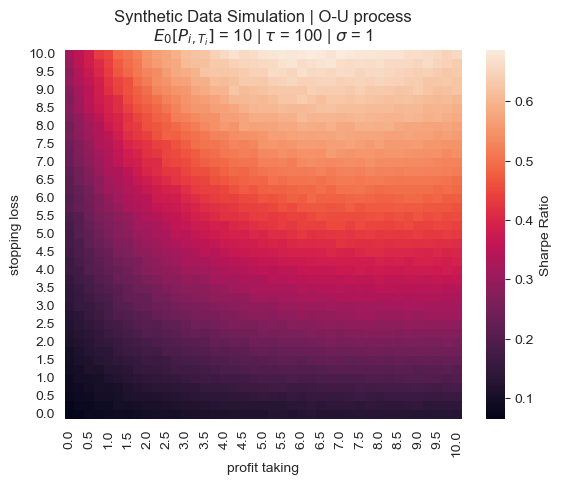

In [33]:
sns.heatmap(sharpe_grid, cbar_kws = {"label": "Sharpe Ratio"})
plt.title('Synthetic Data Simulation | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 10 | $\tau$ = 100 | $\sigma$ = 1')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()